## **Integrantes:**
- Juan Bojato
- Jesus Santiago
- Jefferson Sierra

# **Instrucciones**

Para ejecutar el código se deben de seguir las siguientes instrucciones:


1.   **Cargar imagen** En la barra lateral izquierda.
2.   Presionar Control + F9 (Run All Cells).
3. Escribir el nombre de la imagen que se nos pide al final del documento.
4.   Ver los resultados al final del documento.





## **Imagen a Texto -> Obteniendo Matriz de Adyacencia**

Para obtener la matriz de adyacencia, se utilizó una librería llamada **Tesseract OCR** y un "wrapper" para python de esta librería llamado **pytesseract**. Para obtener un mejor reconocimiento de caracteres con esta librería es necesario primero preprocesar la imagen a través de una serie de ajustes.

**Importación e instalación de librerias necesarias**

In [ ]:
!sudo apt install tesseract-ocr
!pip3 install pytesseract
import shutil
import os
import random
import numpy as np
import cv2
from pytesseract import Output
try:
 from PIL import Image
except ImportError:
 import Image
from google.colab.patches import cv2_imshow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Importación de 3 librerias esenciales para utilizar Tesseract y declaración de varias funciones útiles para realizar un preprocesamiento de la imagen:

In [ ]:
from PIL import Image
import pytesseract
import string

# Funciones para mejorar la imagen
def thresholding(image):
    return cv2.threshold(image, 0, 210, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
def remove_noise(image):
    return cv2.medianBlur(image,5)



**Funciones para identificar números en el texto extraido de la imagen**

In [ ]:
#Verifica si una cadena puede ser convertida a entero 
def isNumber(str):
    try:
        int(str)
        return True
    except:
        return False

#Returna un numero dada una cadena que contiene caracteres númericos y no númericos 
def fixValue(str):
    fixedValue = ""
    for x in list(str):
        if(isNumber(x)):
            fixedValue+=x
    return int(fixedValue)        


Con la siguiente función, se aplican algunos ajustes a la imagen para adecuarla antes de utilizar la libreria Tesseract. Estos ajustes previos ayudan a disminuir los errores de reconocimiento de caracteres que pueden surgir al momento de utilizar Tesseract. Luego de esto, se muestra la imagen procesada, se extraen los caracteres numéricos y se almacena la matriz de adyacencia en un diccionario que va a ser utilizado en pasos posteriores.

In [ ]:
def img_to_text():

  # Abecedario:
  letters = list(string.ascii_uppercase)

  # Texto a imagen      
  print("Ingresa la ruta de la imagen:", end="")
  path = input();        
  image = cv2.imread(path)

  #img = cv2.resize(image, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
  img = cv2.resize(image, None,fx=3,fy=3,interpolation=cv2.INTER_CUBIC)

  custom_config = r'--oem 3 --psm 6 '
  gray = get_grayscale(img)
  thresh = thresholding(gray)
  cv2_imshow(thresh)
  text = pytesseract.image_to_string(thresh, config=custom_config)
  #print(text)

  # Texto sin espacios al comienzo y al final
  stripped_text = text.strip()
  rows = stripped_text.split("\n")

  matrix= [i.split(" ") for i in rows]

  # Diccionario en blanco:    
  dictionary = {}

  greatest = -1;
  lowest = 9999;

  # Llenar diccionario:
  for i in range(1, len(matrix)):
    row=[]
    for j in range(1, len(matrix[i])):
        value = fixValue(matrix[i][j])
        if (value!=0):
            row.append((letters[j-1], value))
            if(value > greatest):
              greatest = value
              greatestLetter = letters[j-1]
            if(value < lowest):
              lowest = value
              lowestLetter = letters[j-1]
        
    dictionary[letters[i-1]] = row

  print('Matriz de adyacencia:',end="\n\n")

  for key, value in dictionary.items():
      print(key,':',value)
  
  return dictionary,greatestLetter,lowestLetter

# **Busqueda A***

Este algoritmo permite hallar entre la distancia que existe entre el nodo de mayor peso con aquel de menor peso

**Variables globales e imports**

In [ ]:
from collections import deque
 
distance = {}
parents = {}
H = {}

matrix_adjacency = {
        'A': [('B', 5), ('C', 9), ('D', 4)],
        'B': [('C', 1), ('A',5)],
        'C': [('D', 3),('B', 1),('A', 9),('E',1)],
        'D': [('A', 4),('C', 3),('E',5)],
        'E': [('C', 1),('D', 5)]
}

**Función heuristica**

Esta función definida por nosotros está basada en el cuadrado de la cantidad de nodos que tiene el grafo.

In [ ]:
def hfunction (lenght):
    ABECEDARIO="ABCDEFGHIJKLMNOPQRSTUVWXYZ"
   
    for letter in range(0, lenght):
        H[ABECEDARIO[letter]] = lenght**2

    return H

**Heuristica de un nodo**

In [ ]:
def heuristic (n):
    return H[n]

 **Menor valor de f**

Dado un valor f equivalente a la suma de dos parametros: **g** y **h**, se busca aquel nodo que posea el menor valor de f. Donde:

 **g**= El costo que equivale moverse desde el nodo en especifico a otro nodo **(distance)**.

**h** = Heuristica de un nodo (heuristic)


In [ ]:
def low_value (node,nodesInspected,distance):
    for element in nodesInspected:
                # f = g + h.
                if node == None or distance[element] + heuristic(element) < distance[node] + heuristic(node):
                    node = element;
                   
    return node


**Función de error**

Si un nodo no existe o el grafo está vacio se mostrará el siguiente error:


In [ ]:
def errorPath (n):
    if n == None:
        print('Error: No existe un camino')
        return None
    return False

**Camino encontrado!**

Cuando se ha terminado de recorrer el grafo y un camino ha sido hallado, se mostrará el camino empleado.

In [ ]:

def pathFound(n,lowerNode,higherNode,parents):
  #Si el nodo visitado equivale al nodo de destino, se traza el camino recorrido.
    if n == higherNode:
        path = []
      #El vector parents contiene los padres de cada nodo visitado correspondientemente.
        while parents[n] != n:
            path.append(n)
            n = parents[n]

        path.append(lowerNode)

        path.reverse()
       
        print('Camino encontrado: {}'.format(path))
        return None, path
    else:
        return n,None


**Función de Busqueda A***

En esta función se busca hallar el camino mas corto existente de un nodo a otro. Para ello se recurren a las distancias entre los nodos, sus padres **(parents)** y se separan en dos grupos:

**nodesInspected** = Son aquellos nodos que han sido visitados mientras que sus nodos vecinos no.

**nodesVisited** = Son aquellos nodos que han sido visitados tanto ellos como sus vecinos.


In [ ]:
def search_A(matrix_adjacency,n,nodesInspected,NodesVisited,distance,parents):

        for (node, weight) in matrix_adjacency[n]:
          # Si un nodo no ha sido visitado se agrega a nodosInspected y se le asigna su respectiva distancia y padre.
                if node not in nodesInspected and node not in NodesVisited:
                    nodesInspected.add(node)
                    parents[node] = n
                    distance[node] = distance[n] + weight
                else:
                  # Si un nodo ha sido visitado pero sus vecinos no, se comprueba si hay una distancia menor a la existente para llegar al nodo.
                    if distance[node] > distance[n] + weight:
                        distance[node] = distance[n] + weight
                        parents[node] = n

                        if node in NodesVisited:
                          # Cuando un nodo y sus vecinos han sido visitados, se retiran de la búsqueda.
                            NodesVisited.remove(node)
                            nodesInspected.add(node)
       
        nodesInspected.remove(n)
        NodesVisited.add(n)
        print("Nodo visitado",NodesVisited)
        return NodesVisited, nodesInspected;


**Método principal**

Se declaran las variables inicialmente y se procede a aplicar las funciones vistas con anterioridad hasta que todos los nodos hayan sido visitados, o en su defecto, los nodos que conducen al nodo destino.

In [ ]:
def main(lowerNode, higherNode,matrix_adjacency):
        nodesInspected = set([lowerNode])
        hfunction(len(matrix_adjacency))
        NodesVisited = set([])
        distance[lowerNode] = 0
        parents[lowerNode] = lowerNode
        
        while len(nodesInspected) > 0:
            n = None
            path = []

          # Se obtiene el nodo con menor f.
            n = low_value(n,nodesInspected,distance)

           # Si hay error el algoritmo mostrará el respectivo mensaje.
            if(errorPath(n)==None): return None

            # se busca si lo hay el camino al nodo destino.
            n, path = pathFound(n,lowerNode,higherNode,parents)

            # Si ya no hay nodos se retorna el camino.
            if(n==None): return path

            # Se aplica la Busqueda A*
            NodesVisited, nodesInspected = search_A(matrix_adjacency,n,nodesInspected,NodesVisited,distance,parents)

        print("No existe un camino")
        return None
            


## **Grafo con el camino más corto dibujado**

**Funcion graficar**

Se importan las librerias necesarias para realizar dibujar el grafo —matplotlib, networkx, ademas de las librerias numpy para el manejo de arreglos y string para el abecedario—
Con la funcion graficar y usando principalmente la libreria networkx dibujamos los nodos con sus respectivos label y las aristas con sus respectivos pesos. Con la libreria string se le asigna automaticamente cada una de las letras a cada nodo y finalmente con la libreria matplotlib se muestra el grafo en pantalla.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import string

def graficar(caminocorto, matrix_adjacency):
  alphabet_string = string.ascii_uppercase
  alphabet_list = list(alphabet_string)
  
  matriz=listtomatriz(matrix_adjacency,  alphabet_list) #Creamos la matriz de adyacencia a partir de la lista de adyacencia
  G = nx.from_numpy_matrix(np.array(matriz))#Se crea el grafo a partir de la matriz
  pos=nx.spring_layout(G)
  
  nx.draw_networkx_nodes(G,pos, np.arange(len(list(matrix_adjacency.keys()))), 
                         node_color='b', node_size=500, alpha=0.7)#Dibujamos todos los nodos del grafo
  
  nx.draw_networkx_edges(G,pos,edgelist=edges(matriz),width=1,alpha=0.5
                         ,edge_color='g')#Dibujamos todas las aristas del grafo
  
  nx.draw_networkx_edges(G,pos,edgelist=edgesshortcut(caminocorto,alphabet_list)
  ,width=5,alpha=0.5,edge_color='r')#Resaltamos las aristas que pertenecen al camino optimo
  
  labels={}#Se le asigna a cada uno de los nodos su respectiva letra
  for i in range(len(list(matrix_adjacency.keys()))): #Recorre todos los nodos
    labels[i]=r'$'+alphabet_list[i]+'$'
  #Dibujamos la respectiva letra de cada nodo
  nx.draw_networkx_labels(G,pos,labels,font_size=16)
  
  nx.draw_networkx_edge_labels(
      G, pos, edge_labels=nx.get_edge_attributes(G, "weight"))#Se obtienen y dibujan los pesos de cada arista

  plt.axis('off')
  plt.show()

**Funcion convertir lista de adyacencia a matriz de adyacencia**

Dado que la representacion del grafo esta dada por una lista de adyacencia y la libreria —networkx— requiere como parametro una matriz de adyacencia con pesos para poder dibujar el grafo, convertimos de lista a matriz.
Transformamos las letras que representan los nodos en numeros —indices del abecedario— para usarlos como indices en la matriz de adyacencia, luego asignamos el valor del peso en las celdas para representar las conexiones.

In [ ]:
def listtomatriz(matrix_adjacency, alphabet_list):
  strings1 = [];strings = []
  valores1=[];valores=[]
  aristas=list(matrix_adjacency.values())
  for i in aristas:
    for j in i:
        strings1.append(j[0])#Obtenemos las conexiones (letras) de un nodo
        valores1.append(j[1])#Obtenemos los pesos de las conexiones de un nodo
    strings.append(strings1.copy())#Guardamos las conexiones encontradas
    strings1.clear()
    valores.append(valores1.copy())#Guardamos los pesos encontrados
    valores1.clear() #Limpiamos ambos vectores para la siguiente iteracion

  matriz=np.zeros((len(valores),len(valores)))
  cont1=0;cont2=0
  for i in strings:
    for j in i:
        #Guardamos el peso de las conexiones usando los indices del abecedario
        matriz[cont1][alphabet_list.index(j)]=valores[cont1][cont2]
        cont2=cont2+1
    cont1=cont1+1
    cont2=0   
  return matriz

**Funcion aristas**

Recorremos la matriz de adyacencia y extraemos los indices i,j de la matriz donde existan conexiones para crear una lista de parejas de nodos para dibujar las respectivas aristas.

In [ ]:
def edges(matriz):
  aristas=[]
  for i in range(len(matriz[0])):
    for j in range(len(matriz[0])):
        if(matriz[i][j] != 0):
          aristas.append([i,j])#Guardamos solo las conexiones que tienen peso en la matriz de adyacencia (aristas)
  aristas = np.array(aristas, dtype='int');tupla=[]#Transformamos los valores de float a int
  for i in range(len(aristas)):
    tupla.append(tuple(aristas[i]))#Guardamos las aristas como tuplas
  return tupla

**Funcion aristas camino corto**

La lista de nodos con el camino mas corto tambien es dado en letras, las convertimos a indices del abecedario para enviarlas a la funcion graficar. Recorremos la lista y creamos parejas de nodos para resaltar las aristas del camino optimo en el dibujo final. 


In [ ]:
def edgesshortcut(caminocorto,alphabet_list):
  aristascamino=[]
  for i in range(len(caminocorto)):
    caminocorto[i]=alphabet_list.index(caminocorto[i])#Cambiamos las letras por su respectivo numero
    if(i>0):#El numero de aristas es menor en una unidad a la de nodos
      aristascamino.append(tuple([caminocorto[i-1],caminocorto[i]]))#Guardamos las aristas como tuplas
  return aristascamino

# **Resultados finales**

**Imagen a texto**

Ingresa la ruta de la imagen:./large_example.bmp


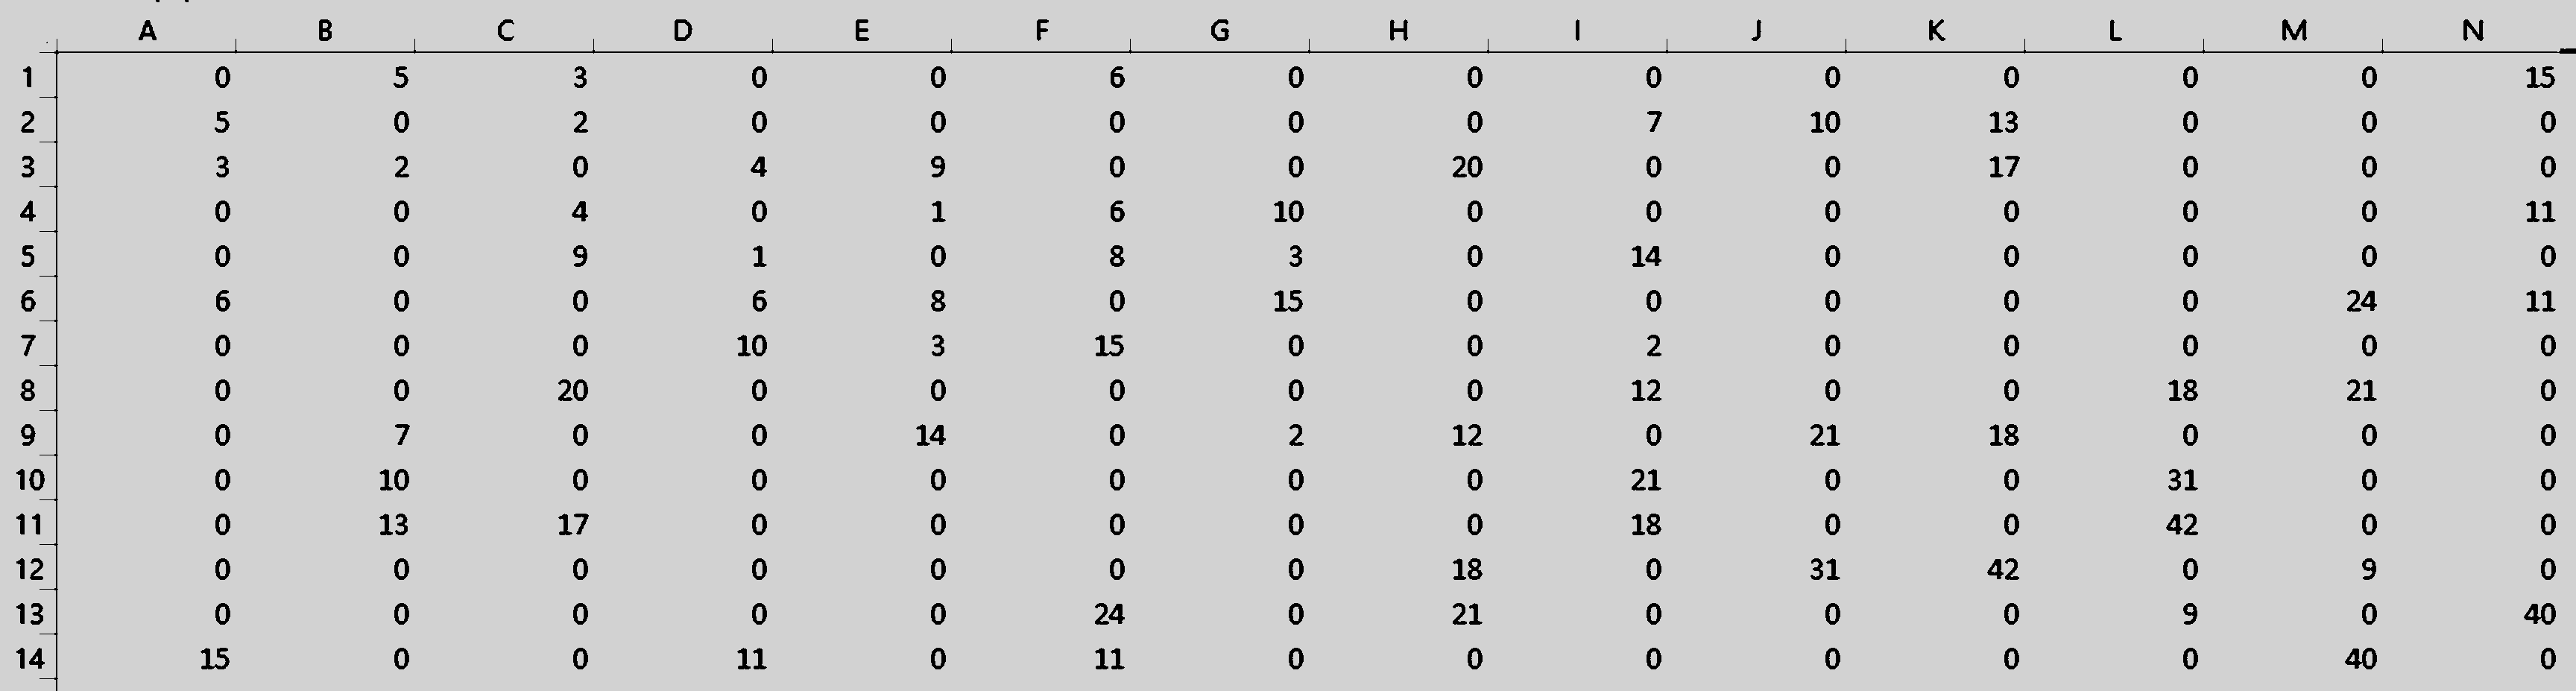

Matriz de adyacencia:

A : [('B', 5), ('C', 3), ('F', 6), ('N', 1)]
B : [('A', 5), ('C', 2), ('I', 7), ('J', 10), ('K', 13)]
C : [('A', 3), ('B', 2), ('D', 4), ('E', 9), ('H', 20), ('K', 17)]
D : [('C', 4), ('E', 1), ('F', 6), ('G', 10), ('N', 11)]
E : [('C', 9), ('D', 1), ('F', 8), ('G', 3), ('I', 14)]
F : [('A', 6), ('D', 6), ('E', 8), ('G', 1), ('M', 24), ('N', 11)]
G : [('D', 10), ('E', 3), ('F', 1), ('I', 2)]
H : [('C', 20), ('I', 12), ('L', 18), ('M', 21)]
I : [('B', 7), ('E', 14), ('G', 2), ('H', 12), ('J', 21), ('K', 18)]
J : [('B', 10), ('I', 21), ('L', 31)]
K : [('B', 13), ('C', 17), ('I', 18), ('L', 42)]
L : [('H', 18), ('J', 31), ('K', 42), ('M', 9)]
M : [('F', 24), ('H', 21), ('L', 9), ('N', 40)]
N : [('A', 1), ('D', 11), ('F', 11), ('M', 40)]


In [ ]:
matriz_ad,startNode,endNode = img_to_text()

**Camino encontrado**

In [ ]:
caminocorto=main(startNode, endNode,matriz_ad)

Nodo visitado {'L'}
Nodo visitado {'M', 'L'}
Nodo visitado {'M', 'L', 'H'}
Nodo visitado {'M', 'L', 'I', 'H'}
Nodo visitado {'L', 'H', 'M', 'I', 'J'}
Nodo visitado {'L', 'H', 'M', 'I', 'G', 'J'}
Nodo visitado {'L', 'H', 'M', 'I', 'F', 'G', 'J'}
Nodo visitado {'E', 'L', 'H', 'M', 'I', 'F', 'G', 'J'}
Nodo visitado {'E', 'L', 'D', 'H', 'M', 'I', 'F', 'G', 'J'}
Nodo visitado {'E', 'L', 'D', 'B', 'H', 'M', 'I', 'F', 'G', 'J'}
Nodo visitado {'E', 'L', 'D', 'C', 'B', 'H', 'M', 'I', 'F', 'G', 'J'}
Nodo visitado {'E', 'A', 'L', 'D', 'C', 'B', 'H', 'M', 'I', 'F', 'G', 'J'}
Camino encontrado: ['L', 'M', 'F', 'A', 'N']


**Grafo con el camino hallado**

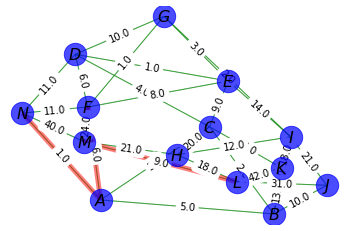

In [ ]:
graficar(caminocorto, matriz_ad)